In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

import os

In [2]:
def b_transition(var, rate, dt=1):
    kb        = np.maximum(1.0 - math.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(var, kb )

    return num_ind

def deterministic_transition(var, rate, dt=1):
    return var*dt*rate

def model(x, beta, gamma, N=1e6, dt=1):
    S = x[0]
    I = x[1]
    R = x[2]

    gamma = gamma
    beta  = beta
    foi   =  beta * (I) / N

    # Stochastic transitions
    s2i     =  b_transition(S, dt*foi)                 # susceptible to exposed
    i2r     =  b_transition(I, dt*gamma) # exposed to infected reported who are not going to die

    # Updates
    S    = S   - s2i       # Susceptible
    I    = I   + s2i - i2r  # Infected reported
    R    = R   + i2r       # Recovered
    C    = s2i


    return [S, I, R, C]


<AxesSubplot:xlabel='date'>

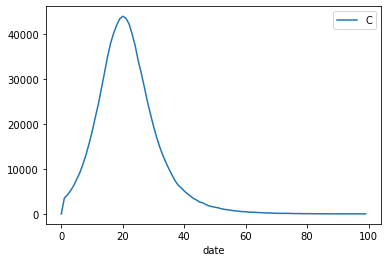

In [3]:
N = 1e6
num_days = 100
x  = [N-0.01*N, 0.01*N, 0, 0]

x_sol      = np.zeros((num_days, 4))
gamma_truth = 1/7
beta_truth  = 2.5 * gamma_truth
pop = 1e5

x_sol[0, :] = x
for d_idx in range(1, num_days):
    x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta_truth, gamma_truth, N=1e6)

x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"
dates = x_sol_df.index.values

x_sol_df.plot(y="C")


In [13]:
def negative_binomial_loglikelihood(real_world_observations, model_observations, particle_dispersion=0.5):
    # Assume probability particle distribution is in the second dimension
    # Γ(r + y)p**r(1 − p)y) − ln (Γ(r)Γ(y + 1)


    # Assume log-likelihood is a negative binomial dist
    ll =  np.sum(np.log(np.random.gamma(real_world_observations+real_world_observations)) + model_observations*np.log(1-particle_dispersion) - np.log(np.random.gamma(real_world_observations+1)), 1)

    return ll

def poisson_loglikelihood(real_world_observations, model_observations, num_times=100):
    nll =  -np.sum(model_observations,1) + np.sum(real_world_observations*np.log(model_observations),1) # Poisson LL
    return - nll

def normal_loglikelihood(real_world_observations, model_observations, error_variance=None, A=0.1, num_times=100):
    if not error_variance:
        error_variance = 1+(0.2*real_world_observations)**2

    nll =  A * np.exp(-0.5 * (real_world_observations-model_observations)**2/error_variance) # Normal LL
    return - nll

def normalize_weights(weights):
    return weights / np.sum(weights)

# Particle Filter with importance sampling

In [14]:

obs_world_df = x_sol_df[["C"]]
obs_world_df

num_particles = 1e5


priors_range_dict  = {}
priors_range_dict["beta"]  = [0.2, 1.5]  # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3] # Recovery rate range

def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

num_particles = int(1e4)

particles_prior = sample_params_uniform(priors_range_dict, num_ensembles=num_particles)
weigths         = np.zeros((1, num_particles))

# Init state space for all particles
x_init = np.array([[N-0.01*N, 0.01*N, 0, 0]]).T * np.ones((1, num_particles))
x = x_init
weights = np.ones((num_particles)) / num_particles
num_vars = 4
num_steps = len(dates)

weigths_all      = np.full((num_particles, num_steps), np.nan)
weigths_all[:,0] = weights

obs = np.full((num_particles, len(dates)-1), np.nan)

# PARTICLE FILTER WITH IMPORTANCE SAMPLING
for idx_date, date in tqdm(enumerate(dates[1:])):
    # Integrate all particles.
    x_ens = np.full((num_vars,num_particles), np.nan)
    for idx_ens in range(num_particles):
        beta   = particles_prior[0, idx_ens]
        gamma  = particles_prior[1, idx_ens]

        x_ens[:,idx_ens] = model(x[:,idx_ens], beta, gamma, N=pop)

    x = x_ens.copy()

    # Compute weights
    obs_time  = obs_world_df.loc[date]["C"]      # World observations
    model_obs = np.expand_dims(x_ens[-1, :], 0)  # Model observations

    obs[:,idx_date] = model_obs

    # compute likelihood and normalize it
    ll = negative_binomial_loglikelihood(obs_time.T, model_obs.T, particle_dispersion=0.5)
    weights = weights * ll
    weights = normalize_weights(weights)
    # Resampling new particles
    # new_particles = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights[:])
    # x       = x[:, new_particles]
    # weights = weights[new_particles]
    weigths_all[:,idx_date+1] = weights


99it [00:17,  5.66it/s]


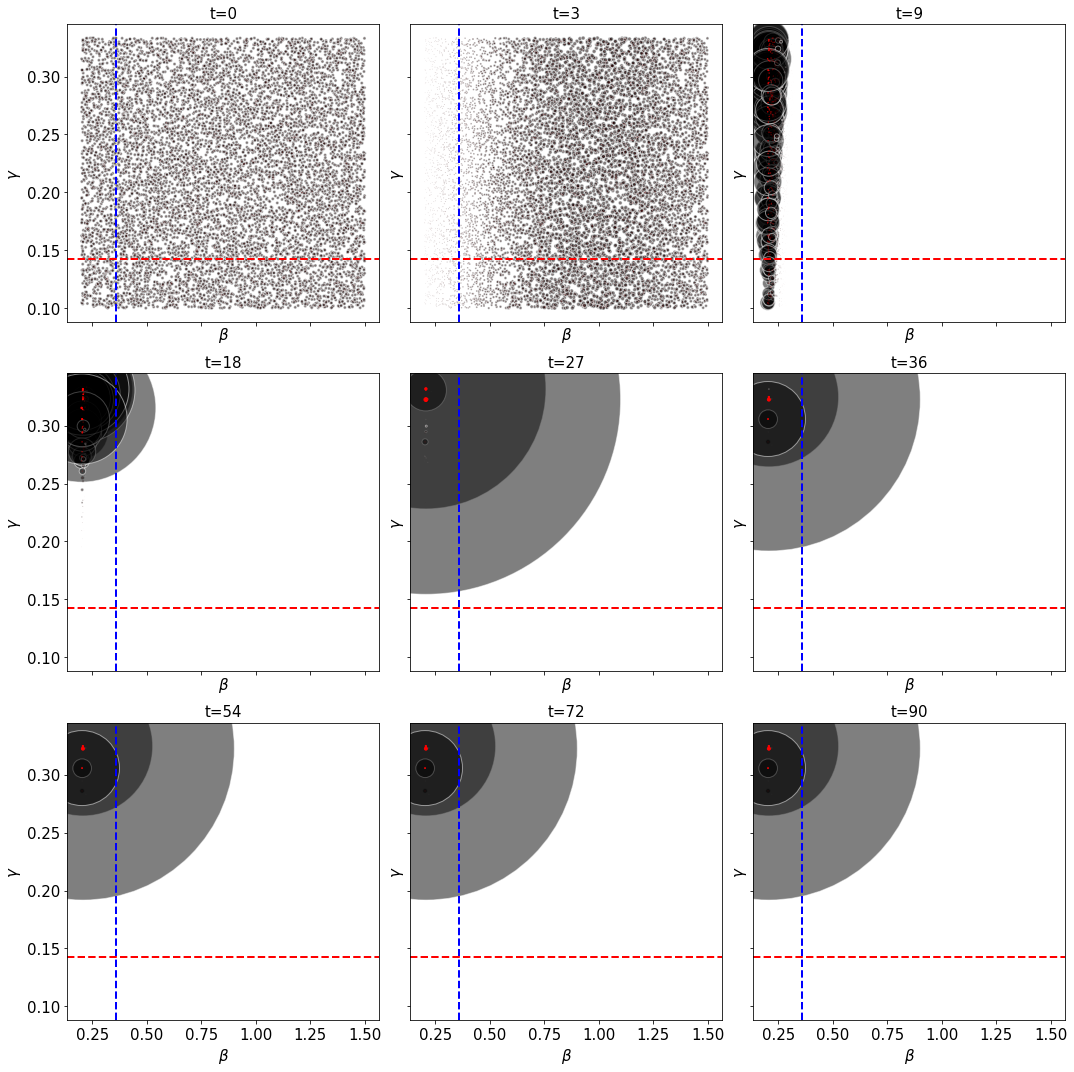

In [22]:
# Plot particle convergence just for ploting
particles_convergence = [0, 3, 9,
                        18, 27, 36,
                        54, 72, 90]

fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

for idx, axi in enumerate(ax.flatten()):
    sizes = num_particles*weigths_all[:,particles_convergence[idx]]

    idx_none = np.where(sizes<1e-6)[0]
    sizes[idx_none] = None

    axi.scatter(particles_prior[0,:], particles_prior[1,:], edgecolor="w", facecolor="k", s=10*sizes, alpha=0.5)
    axi.scatter(particles_prior[0,:], particles_prior[1,:], edgecolor="red", facecolor="red", s=10*sizes/num_particles)

    axi.set_ylabel(r"$\gamma$", fontsize=15)
    axi.set_xlabel(r"$\beta$", fontsize=15)
    axi.set_title(f"t={particles_convergence[idx]}", fontsize=15)
    axi.axvline(x=beta_truth, color="blue", lw=2, linestyle="--")
    axi.axhline(y=gamma_truth, color="r", lw=2, linestyle="--")
    axi.tick_params( which='both', axis='both', labelsize=15)
plt.tight_layout()


# Particle filter with Resampling

In [58]:
x_sol_df

obs_world_df = x_sol_df[["C"]]
obs_world_df

num_particles = 1e5

priors_range_dict  = {}
priors_range_dict["beta"]  = [0.2, 1.5]  # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3] # Recovery rate range

def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

num_particles = int(1e4)


particles_prior = sample_params_uniform(priors_range_dict, num_ensembles=num_particles)
# Init state space for all particles
x_init = np.array([[N-0.01*N, 0.01*N, 0, 0]]).T * np.ones((1, num_particles))
x      = x_init

# Initial Weights set as 1/num_particles
num_vars = 4
num_steps = len(dates)

weigths_all      = np.full((num_particles, num_steps), np.nan)
weigths_all[:,0] = np.ones((num_particles)) / num_particles

particles_post_all        = np.full((2, num_particles, num_steps), np.nan)
particles_post_all[:,:,0] = particles_prior

# PARTICLE FILTER WITH IMPORTANCE SAMPLING
for idx_date, date in tqdm(enumerate(dates[1:])):
    particles_post = particles_prior.copy()
    # Integrate all particles.
    x_ens = np.full((num_vars,num_particles), np.nan)
    for idx_ens in range(num_particles):
        beta   = particles_post[0, idx_ens]
        gamma  = particles_post[1, idx_ens]

        x_ens[:,idx_ens] = model(x[:,idx_ens], beta, gamma, N=pop)

    x = x_ens.copy()

    # Compute weights
    obs_time  = obs_world_df.loc[date]["C"]      # World observations
    model_obs = np.expand_dims(x_ens[-1, :], 0)  # Model observations

    obs[:,idx_date] = model_obs

    # Compute likelihood and normalize it
    ll      = negative_binomial_loglikelihood(obs_time.T, model_obs.T, particle_dispersion=0.5)
    weights = weigths_all[:, idx_date] * ll

    weights = np.maximum(weights * ll, 0)
    weights = normalize_weights(weights)

    # Resampling new particles
    new_particles = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)

    x            = x[:, new_particles]
    #weights      = normalize_weights(weights[new_particles])

    particles_post                     = particles_prior[:, new_particles]
    particles_post_all[:,:,idx_date+1] = particles_post
    particles_prior                    = particles_post.copy()
    weigths_all[:,idx_date+1]          = weights


99it [00:17,  5.56it/s]


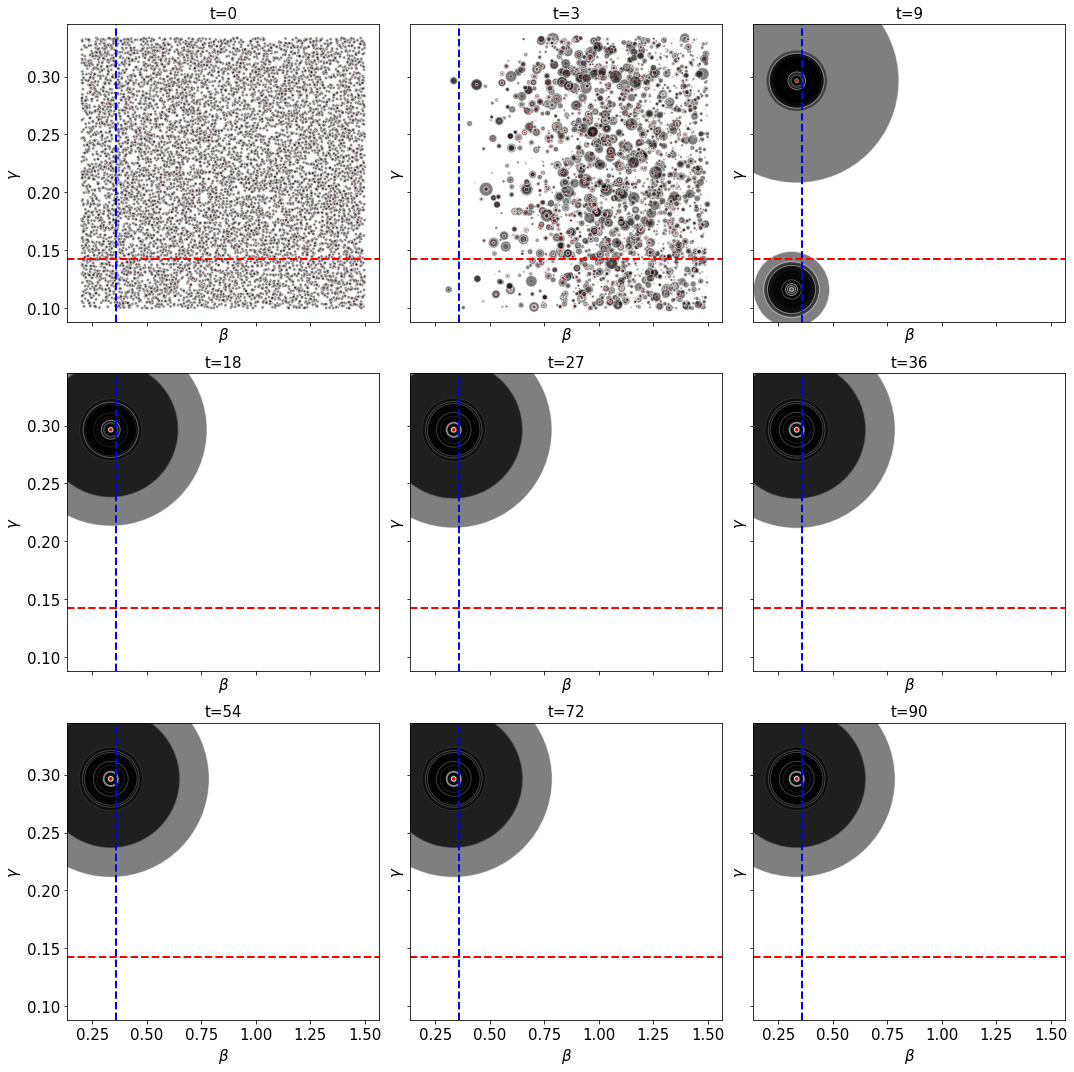

In [59]:
# Plot particle convergence just for ploting
particles_convergence = [0, 3, 9,
                        18, 27, 36,
                        54, 72, 90]

#particles_convergence = np.arange(0,10,1)

fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
for idx, axi in enumerate(ax.flatten()):
    idx_date = particles_convergence[idx]

    sizes = num_particles*weigths_all[:,idx_date]

    idx_none = np.where(sizes<1e-6)[0]
    sizes[idx_none] = None

    axi.scatter(particles_post_all[0,:, idx_date], particles_post_all[1,:, idx_date], edgecolor="w", facecolor="k", s=10*sizes, alpha=0.5)
    axi.scatter(particles_post_all[0,:, idx_date], particles_post_all[1,:, idx_date], edgecolor="red", facecolor="red", s=10*sizes/num_particles)

    axi.set_ylabel(r"$\gamma$", fontsize=15)
    axi.set_xlabel(r"$\beta$", fontsize=15)
    axi.set_title(f"t={idx_date}", fontsize=15)
    axi.axvline(x=beta_truth, color="blue", lw=2, linestyle="--")
    axi.axhline(y=gamma_truth, color="r", lw=2, linestyle="--")
    axi.tick_params( which='both', axis='both', labelsize=15)

plt.tight_layout()

In [ ]:
def update_weights(weights, ):
    # Update weights using sequential importance sampling
    # w_{t-1}:       Previous weights
    # p(y_t|z_t):    Adjust state space
    # p(z_t|z_t-1 )
    # q(z_t)         Probability of observing the observation (Poisson)
    # w_t <- w_{t-1} * p(y_t|z_t) * p(z_t|z_t-1 ) / q(z_t)




# Particle Filter with Proposal Density

In [ ]:

def resample_particles(particles, particle_weights, num_particles=1e5, proportion_resampled=0.1):
    """[summary]

    Args:
        particles ([type]): Dictionary with the particles of the SMC
        num_particles ([type], optional): Number of particles used. Defaults to 1e5.
        proportion_resampled (float, optional): Proportion of particles to be resampled. Defaults to 0.1.
    """

    # Normalize weights in case they were not.
    if particle_weights.sum()!=1:
      particle_weights = particle_weights / particle_weights.sum(particle_weights)



In [ ]:
resample_particles = function(particles_in, num_samples_in = (np * prop_new)){
k_trans          = log(particles_in$k)
rho_trans        = logit(particles_in$rho)
dispersion_trans = log(particles_in$dispersion)

particles_trans = data.frame(k_trans, rho_trans, dispersion_trans)
particles_new   = rmvnorm(num_samples_in, mean = colMeans(particles_trans), sigma = cov(particles_trans))

particles_out = data.frame(
  k = exp(particles_new[,1]),
  rho = inv_logit(particles_new[,2]),
  dispersion = exp(particles_new[,3])
)

return(particles_out)
}

def resample_particles(particles, particle_weights, num_particles=1e5, proportion_resampled=0.1):
    """[summary]

    Args:
        particles ([type]): Dictionary with the particles of the SMC
        num_particles ([type], optional): Number of particles used. Defaults to 1e5.
        proportion_resampled (float, optional): Proportion of particles to be resampled. Defaults to 0.1.
    """


    if particle_weights.sum()!=1:
      particle_weights = particle_weights / particle_weights.sum(particle_weights)

